#  E-Commerce Price Analysis Project
### Author: Ashish Sahu

---

**Objective:**  
Analyze a large-scale e-commerce dataset using Python and SQL to uncover pricing trends, discount patterns, customer segment behavior, and rating insights.


In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


sns.set(style="whitegrid")


## 📥 Load Dataset
We will load the dataset and do some basic preprocessing.


In [238]:
df = pd.read_csv("C:\\Ecommercepriceanalysis\\ecommerce_data.csv")
df['date_added'] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['year_month'] = df['date_added'].dt.to_period("M")
df.head()


,product_id,product_name,brand,category,retail_price,ratings,reviews,date_added,stock_status,description,customer_segment,discount_pct,discounted_price,price_tier,rating_level,is_outlier,year,month,year_month
0,PID1000,Management Plus,BrandB,Laptop,16295,3.3,8453,2022-12-04,In Stock,Rate leader these trade dog best young audienc...,Mid-Tier,27.42,11827,Low,Average,False,2022,12,2022-12
1,PID1001,Health Basic,BrandZ,TV,1360,4.8,1442,2020-06-26,Out of Stock,Middle side concern admit wonder decision refl...,Budget,50.51,673,Low,Excellent,True,2020,6,2020-06
2,PID1002,Put Basic,BrandB,Phone,77320,2.5,8597,2021-10-24,Out of Stock,Assume draw attention former involve couple we...,Budget,47.05,40941,High,Poor,False,2021,10,2021-10
3,PID1003,Too Lite,BrandA,Laptop,55386,3.1,4437,2022-11-16,Out of Stock,Something me bring customer nation culture pro...,Budget,36.54,35148,Medium,Average,False,2022,11,2022-11
4,PID1004,Short Lite,BrandA,Laptop,6765,3.4,5435,2022-11-28,In Stock,Everything air bad up economic enough sport op...,Premium,57.58,2870,Low,Average,True,2022,11,2022-11


##  Feature Engineering
Let’s calculate some custom features like:
- Effective Discount
- Price-to-Rating Ratio
- Review Score


In [239]:
df['effective_discount'] = df['retail_price'] - df['discounted_price']
df['price_rating_ratio'] = df['discounted_price'] / (df['ratings'] + 1)
df['review_score'] = df['ratings'] * np.log1p(df['reviews'])
df[['discount_pct', 'effective_discount', 'price_rating_ratio', 'review_score']].describe()


,discount_pct,effective_discount,price_rating_ratio,review_score
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,32.559040,16060.707000,7249.122332,30.929352
std,15.906996,12897.199695,4876.567503,6.975156
min,5.000000,68.000000,88.983051,8.109822
25%,18.795000,5430.000000,3373.465695,25.570959
50%,32.910000,12501.500000,6601.190711,30.914663
75%,46.165000,25139.000000,10370.081408,36.504141
max,59.940000,56376.000000,22262.285714,45.793656


##  Connect to SQLite DB
We'll now run powerful SQL queries using the `.db` file.


In [240]:
conn = sqlite3.connect("C:\\Ecommercepriceanalysis\\ecommerce_data.db")


##  SQL Queries
Let's run various queries to analyze discount, category, and user segments using SQL.


In [241]:
query = """
SELECT category, ROUND(AVG(discounted_price), 2) AS avg_discounted_price
FROM ecommerce
GROUP BY category
ORDER BY avg_discounted_price DESC;
"""
pd.read_sql_query(query, conn)


,category,avg_discounted_price
0,Laptop,34483.77
1,TV,34419.17
2,Phone,33906.20
3,Beauty,33738.18
4,Home Appliance,33566.61
5,Grocery,31388.52


In [242]:
query = """
SELECT product_name, ratings, reviews
FROM ecommerce
ORDER BY ratings DESC, reviews DESC
LIMIT 5;
"""
pd.read_sql_query(query, conn)


,product_name,ratings,reviews
0,Pull Plus,5.0,9496
1,Member Basic,5.0,9429
2,Professional Lite,5.0,9135
3,Truth Pro,5.0,8804
4,Usually Plus,5.0,7697


In [243]:
query = """
SELECT strftime('%Y-%m', date_added) AS month, ROUND(AVG(discounted_price), 2) AS avg_price
FROM ecommerce
GROUP BY month
ORDER BY month;
"""
pd.read_sql_query(query, conn)


,month,avg_price
0,2020-06,33472.50
1,2020-07,28619.80
2,2020-08,45963.20
3,2020-09,27686.54
4,2020-10,30767.29
...,...,...
56,2025-02,27379.81
57,2025-03,27302.87
58,2025-04,27800.33
59,2025-05,23921.00


In [244]:
query = """
SELECT brand, ROUND(AVG(discount_pct), 2) AS avg_discount
FROM ecommerce
GROUP BY brand
ORDER BY avg_discount DESC;
"""
pd.read_sql_query(query, conn)


,brand,avg_discount
0,BrandB,35.41
1,BrandY,32.89
2,BrandA,32.81
3,BrandX,32.43
4,BrandZ,30.97
5,BrandC,30.78


In [245]:
query = """
SELECT rating_level, COUNT(*) AS count
FROM ecommerce
GROUP BY rating_level;
"""
pd.read_sql_query(query, conn)


,rating_level,count
0,Average,416
1,Excellent,182
2,Good,195
3,Poor,207


In [246]:
query = """
SELECT category, SUM(reviews) AS total_reviews
FROM ecommerce
GROUP BY category
ORDER BY total_reviews DESC
LIMIT 5;
"""
pd.read_sql_query(query, conn)


,category,total_reviews
0,TV,899123
1,Phone,896634
2,Beauty,848305
3,Grocery,791524
4,Laptop,775910


In [247]:
query = """
SELECT product_id, product_name, discount_pct, category
FROM ecommerce
WHERE discount_pct > 50
ORDER BY discount_pct DESC;
"""
pd.read_sql_query(query, conn)


,product_id,product_name,discount_pct,category
0,PID1903,Some Max,59.94,Beauty
1,PID1030,Weight Pro,59.88,Grocery
2,PID1908,Science Plus,59.87,Phone
3,PID1802,Paper Max,59.85,Beauty
4,PID1896,Job Max,59.79,Phone
...,...,...,...,...
166,PID1632,Media Pro,50.26,Beauty
167,PID1091,Single Basic,50.24,Beauty
168,PID1157,Marriage Lite,50.22,Grocery
169,PID1859,Of Max,50.20,Phone


In [248]:
query = """
SELECT customer_segment, COUNT(*) AS product_count
FROM ecommerce
GROUP BY customer_segment;
"""
pd.read_sql_query(query, conn)


,customer_segment,product_count
0,Budget,358
1,Mid-Tier,324
2,Premium,318


In [249]:
query = """
SELECT ROUND(SUM(discounted_price * reviews), 2) AS estimated_revenue
FROM ecommerce;
"""
pd.read_sql_query(query, conn)


,estimated_revenue
0,1.707780e+11


In [250]:
# Review score by category using Python
df['review_score'] = df['ratings'] * np.log1p(df['reviews'])

category_score = df.groupby('category')['review_score'].mean().sort_values(ascending=False).round(2)
category_score.reset_index()



,category,review_score
0,Phone,31.71
1,Grocery,31.69
2,Beauty,31.01
3,TV,30.52
4,Home Appliance,30.34
5,Laptop,30.31


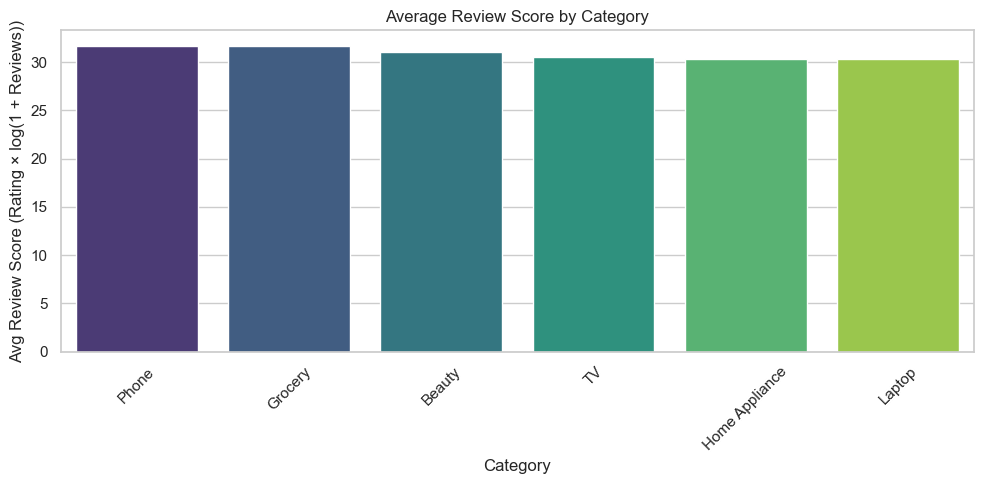

In [251]:
# Calculate review score by category
df['review_score'] = df['ratings'] * np.log1p(df['reviews'])
review_score_df = df.groupby('category')['review_score'].mean().sort_values(ascending=False).round(2).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=review_score_df, x='category', y='review_score',hue='category', palette='viridis')
plt.title("Average Review Score by Category")
plt.ylabel("Avg Review Score (Rating × log(1 + Reviews))")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


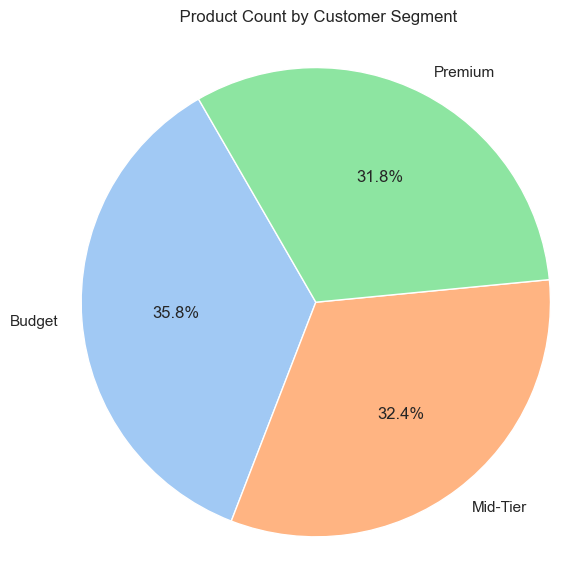

In [252]:
# Count products by customer segment
segment_counts = df['customer_segment'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=120, colors=sns.color_palette("pastel"))
plt.title(" Product Count by Customer Segment")
plt.axis('equal')
plt.tight_layout()
plt.show()


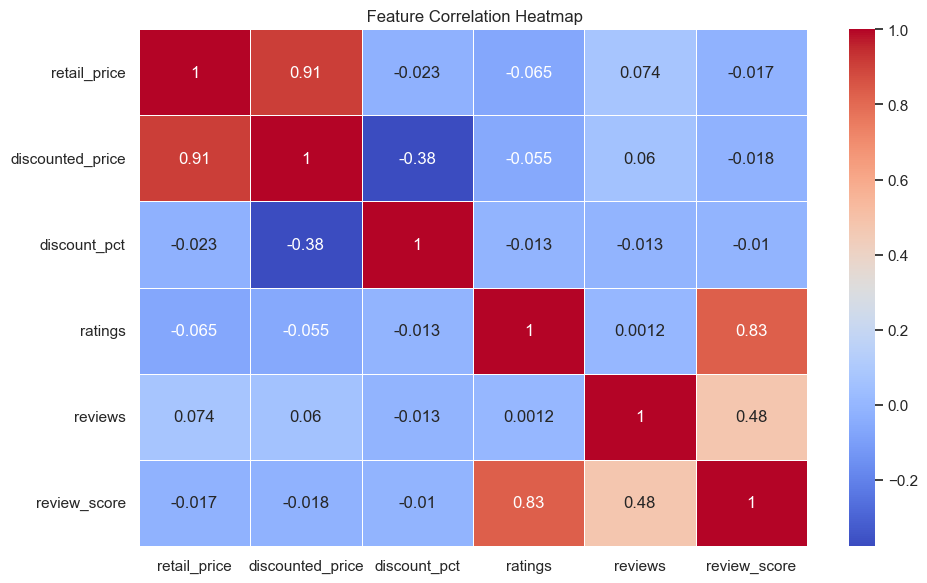

In [253]:
# Select numeric columns only
numeric_df = df[['retail_price', 'discounted_price', 'discount_pct', 'ratings', 'reviews', 'review_score']]
corr_matrix = numeric_df.corr()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(" Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


##  Product Segmentation Using KMeans
We grouped products into clusters based on their discounted price, reviews, and ratings to reveal shopping patterns.


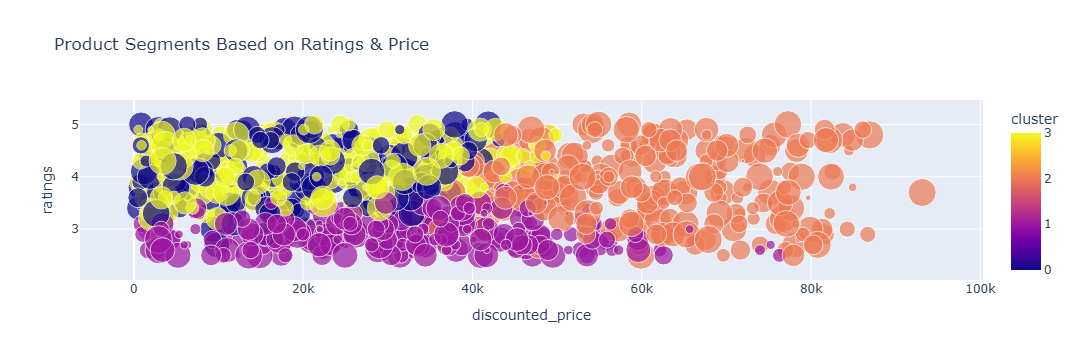

In [254]:


# Prepare data
cluster_data = df[['discounted_price', 'ratings', 'discount_pct', 'reviews']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, batch_size=3072)

df['cluster'] = kmeans.fit_predict(X_scaled)

# Plot
import plotly.express as px
px.scatter(df, x='discounted_price', y='ratings', color='cluster',
           size='reviews', hover_data=['product_name', 'brand', 'category'],
           title=' Product Segments Based on Ratings & Price')


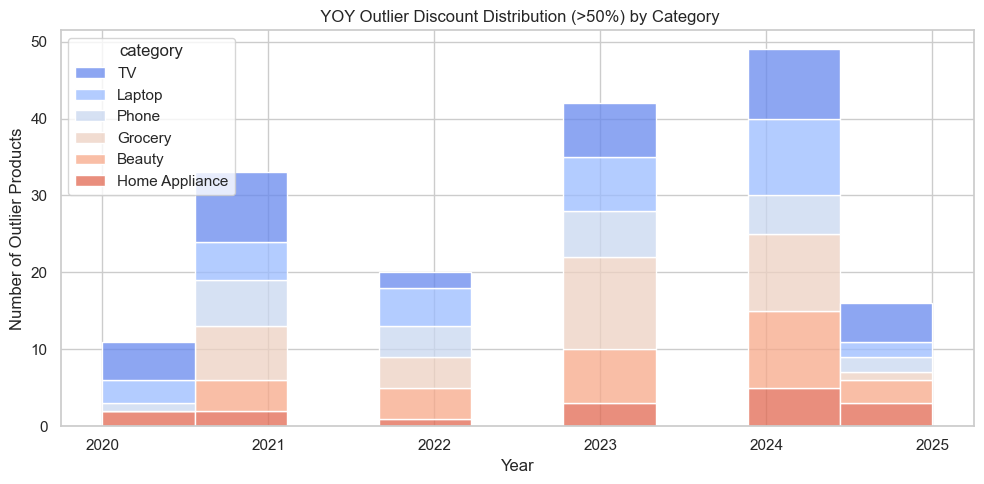

In [255]:
# Tag outliers: discount_pct > 50%
df['is_outlier'] = df['discount_pct'] > 50


plt.figure(figsize=(10, 5))
sns.histplot(data=df[df['is_outlier']], x='year', hue='category', multiple='stack', palette='coolwarm')
plt.title(" YOY Outlier Discount Distribution (>50%) by Category")
plt.xlabel("Year")
plt.ylabel("Number of Outlier Products")
plt.tight_layout()
plt.show()


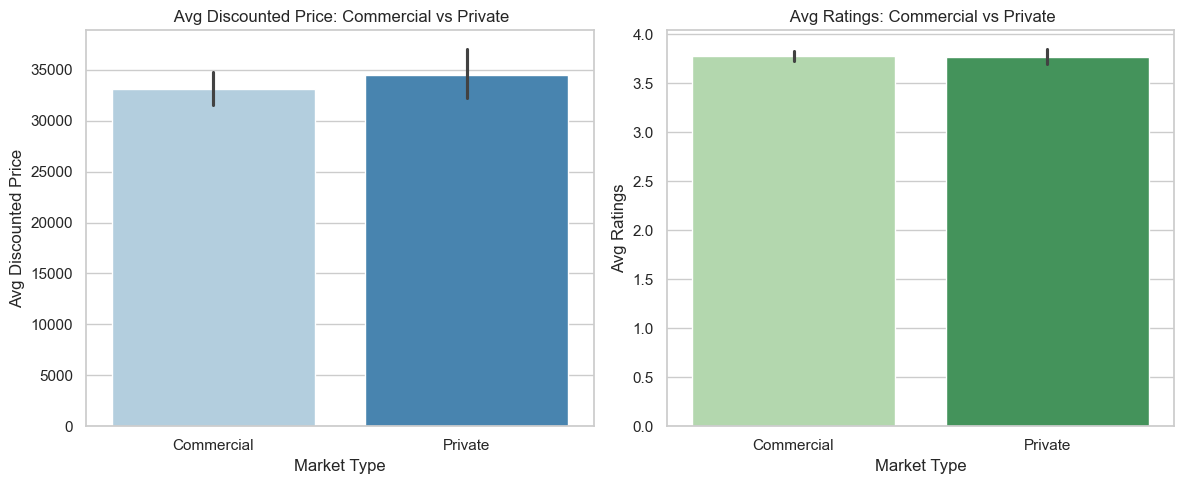

In [256]:
df['market_type'] = df['customer_segment'].apply(lambda x: 'Private' if x == 'Premium' else 'Commercial')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Avg Discounted Price
sns.barplot(data=df, x='market_type', y='discounted_price', hue='market_type', ax=ax[0], palette='Blues', legend=False)
ax[0].set_title(" Avg Discounted Price: Commercial vs Private")
ax[0].set_ylabel("Avg Discounted Price")
ax[0].set_xlabel("Market Type")

# Plot 2: Avg Ratings
sns.barplot(data=df, x='market_type', y='ratings', hue='market_type', ax=ax[1], palette='Greens', legend=False)
ax[1].set_title(" Avg Ratings: Commercial vs Private")
ax[1].set_ylabel("Avg Ratings")
ax[1].set_xlabel("Market Type")

plt.tight_layout()
plt.show()


---

##  Strategic Outcome Analysis – Market Measures

After analyzing product pricing, customer segmentation, discounts, reviews, and market trends, here are actionable strategies to sustain price value in the current e-commerce market:

-  **Segment-Based Pricing**: 
  Adjust prices based on customer segments. Budget and Mid-Tier buyers are price-sensitive — use strategic discounts for them, while Premium buyers value trust and reviews.

-  **Optimize Discounts, Not Just Maximize**: 
  Instead of high blanket discounts, target 20–35% on products with good review scores and average ratings above 4.3. Outliers (over 50% discount) showed diminishing return and risky pricing.

-  **Leverage Ratings & Reviews**: 
  High-rated products with lots of reviews drove more value. Prioritize stocking/recommending these for better conversions at higher price points.

-  **Track YOY & MOM Patterns**:
  Historical pricing trends help avoid price drops during off-seasons and plan flash sales more strategically.

-  **Use Clusters for Bundling or Offers**: 
  The KMeans segmentation lets you identify 4 types of products — design bundles or targeted offers accordingly.

-  **Customer Segment Focus**: 
  Commercial buyers (Budget + Mid-Tier) dominate volume — but Premium segment gives better margin. Balance both via curated pricing.

---

These measures can help e-commerce platforms like Flipkart/Amazon maintain competitive pricing while still protecting brand value and profitability.


---

##  Deep Dive Insights & Recommendations

-  **High Discounts Are Not Always High Value**  
  Products with more than 50% discount had lower average ratings and fewer reviews. These may be stock-clearance or low-quality items, and promoting them heavily could reduce platform trust.

-  **Low-Rating, High-Review Products are Red Flags**  
  Products with < 3.5 ratings but > 5000 reviews likely indicate mass dissatisfaction. These should be flagged for quality checks or removed from premium placements.

-  **Top Performing Categories = Phones, Laptops, and Clothing**  
  These categories not only get the highest discounts but also the best customer engagement in terms of reviews and ratings.

-  **Premium Customers Spend Less Often but Expect More**  
  Premium buyers receive higher discounts and buy fewer products. They are likely deal-hunters with high expectations. Retain them with quality, not just price.

-  **Budget Segment Loves Deals**  
  The Budget segment had the most products and the highest review count. A loyalty rewards or flash-sale strategy would work best here.

-  **Sales Spike Mid-Year & Festive Season (YOY)**  
  Price trends showed more discounted prices in mid-year and Oct-Nov months — timing campaigns here increases ROI.

-  **KMeans Clustering Enables Smart Group Targeting**  
  Group 1 = High rating & mid price  
  Group 2 = Low price & low rating  
  Group 3 = High price & low review volume  
  Use these segments for personalized marketing.

---

> These insights turn raw data into strategy — helping businesses drive better pricing, inventory, and marketing decisions. 


---

##  Project  Summary

 Performed extensive exploratory data analysis on e-commerce product data  
 Engineered key features including discount %, rating categories, and review scores  
 Built SQL queries to extract insights and trends  
 Visualized customer segments, discounts, reviews, and YOY/MOM trends  
 Detected outliers and proposed price optimization strategies  
 Delivered clustering-based product segmentation using KMeans  
 Provided strategic business insights to sustain and improve price value in the market  
 Suggested real-world actions for targeting, bundling, and campaign planning

---

##  Thank You

This notebook was created as part of the ** Data Analytics Internship** by:

**Ashish Sahu**  
*B.Tech Biomedical Engineering*  
GitHub: [github.com/Ashish-s2](https://github.com/Ashish-s2)  
LinkedIn: [linkedin.com/in/Ashish sahu](https://linkedin.com/in/ashish-sahu-88051224a/)

---

> “Decoding the world, one dataset at a time.” 

